In this notebook I will create a data set about movies from a base at filmweb.pl using a BeautifulSoup, try to predict and rating of movies.

## importing

In [1]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## preparing functions

In [2]:
# function getting information about 1 film

def get_info(link):
    
    r=requests.get(link)
    soup=bs(r.content)

    movie_info={}
    
    #info about directors,...,premiere 
    info_box=soup.find(class_='filmPosterSection__info filmInfo')

    keys=info_box.find_all(class_='filmInfo__header')
    values=info_box.find_all(class_='filmInfo__info')

    for i in range(len(keys)):
        key=keys[i].get_text(strip=True).split('(')[0]
        value=values[i].get_text(strip=True).split('(')[0]
        movie_info[key]=value
        
    #info about title and actors
    for i in range(10):
        try:
            base_link='https://www.filmweb.pl'
            actors_link=base_link+soup.find_all(class_='page__moreButton')[i].a['href']

            r2=requests.get(actors_link)
            soup2=bs(r2.content)

            movie_info['title']=soup2.find(class_='filmHeaderSection__title').get_text(strip=True)

            actors_table=soup2.find(class_='filmFullCastSection__list')
            actors_rows=actors_table.find_all(class_='castRoleListElement__info')
            movie_info['actors']=[]

            for index, row in enumerate(actors_rows):
                actor_name=row.a.get_text(strip=True)
                movie_info['actors'].append(actor_name)
                if index > 10:
                    break
        except:
            continue

    #info about boxoffice,..., oryginal title
    info_box3=soup.find(class_='filmOtherInfoSection__group')
    info_rows3=info_box3.find_all(class_='filmInfo__group')

    for index, row in enumerate(info_rows3):
        if index<5:
            keys=row.find_all(class_='filmInfo__header')
            values=row.find_all(class_='filmInfo__info')
            for i in range(2):
                try:
                    key2=keys[i].get_text(strip=True).split('(')[0]
                    value2=values[i].get_text(strip=True).split('(')[0]
                    movie_info[key2]=value2
                except:
                    continue
        else:
            break
    
    #info about rating
    movie_info['rating']=soup.find(class_='filmRating__rateValue').get_text(strip=True)
    
    # change movie_info into a dataframe
    for key in list(movie_info.keys()):
        movie_info[key] = [movie_info[key]]
        
    movie_info = pd.DataFrame(movie_info)
            
    return movie_info

In [3]:
get_info('https://www.filmweb.pl/film/Matrix+Zmartwychwstania-2021-838524?ref=ls_d_0_mat')

,reżyseria,scenariusz,gatunek,produkcja,premiera,nagrody,title,actors,boxoffice,budżet,na podstawie,studio,data produkcji,tytuł oryg.,rating
0,Lana Wachowski,Lana Wachowski/Aleksandar Hemon/ więcej...,Akcja/Sci-Fi,USA,22 grudnia 2021,Film dostał 9 nominacji,Matrix Zmartwychwstania,"[Keanu Reeves, Carrie-Anne Moss, Yahya Abdul-M...",$272 671 006 na świecie$37 571 006 w USA$235 1...,$190 000 000,Lilly Wachowski,NPV Entertainment/Silver Pictures/Village Road...,2021,The Matrix Resurrections,"5,1"


In [4]:
# getting info about given number of the best movies with rate in given range

def create_movie_info_table(max_rate, min_rate, wanted_no_movies):
    movie_info_table = pd.DataFrame()
    ready_no_movies = 0
    page = 1

    while ready_no_movies < wanted_no_movies:
        link = f'https://www.filmweb.pl/films/search?endRate={max_rate}&orderBy=rate&descending=true&startCount=8000&startRate={min_rate}&page={page}'

        r=requests.get(link)
        soup=bs(r.content)

        movies_table = soup.find(id = 'searchResult')
        movies = movies_table.find_all(class_ = 'hits__item')[ : wanted_no_movies - ready_no_movies]
        
        # check if there is no more pages with movies with rate in given range
        if len(movies) == 0:
            break

        for i, movie in enumerate(movies):
            movie_link = 'http://filmweb.pl' + movie.find(class_ = 'filmPreview__link')['href']

            movie_info_row = get_info(movie_link)
            movie_info_table = pd.concat((movie_info_table, movie_info_row))
            ready_no_movies += 1

        page += 1
        
    movie_info_table.reset_index(drop = True, inplace = True)
    
    return movie_info_table

In [7]:
create_movie_info_table(4, 6, 10)

""


In [170]:
# functions to change format of values obtained by using create_movie_info_table

def clean_scenario(value):
    if type(value) == float:
        return value
    else:
        #changing string into list
        lst=value.split('/')
        if 'ięcej' in lst[-1]:
            del lst[-1]
    
        return lst

def clean_prod(value):
    if type(value) == float:
        return value
    else:
        return value.split(', ')

def clean_studio(value):
    if type(value) == float:
        return value
    else:
        if 'ięcej' in ' '.join(value).split()[-1]:
            return ' '.join(value).split()[:-1]
        else:
            return ' '.join(value).split()

def miesiac_ang(miesiac):
    if miesiac=='stycznia' or miesiac=='styczeń':
        return 'January'
    if miesiac=='lutego' or miesiac=='luty':
        return 'February'
    if miesiac=='marca' or miesiac=='marzec':
        return 'March'
    if miesiac=='kwietnia' or miesiac=='kwiecień':
        return 'April'
    if miesiac=='maja' or miesiac=='maj':
        return 'May'
    if miesiac=='czerwca' or miesiac=='czerwiec':
        return 'June'
    if miesiac=='lipca' or miesiac=='lipiec':
        return 'July'
    if miesiac=='sierpnia' or miesiac=='sierpień':
        return 'August'
    if miesiac=='września' or miesiac=='wrzesień':
        return 'September'
    if miesiac=='października' or miesiac=='październik':
        return 'October'
    if miesiac=='listopada' or miesiac=='listopad':
        return 'November'
    if miesiac=='grudnia' or miesiac=='grudzień':
        return 'December'
    
def translating_date(date):
    try:
        lst=date.split()
        if len(lst)==3:
            lst[1]=miesiac_ang(date.split()[1])
            return ' '.join(lst)
        else:
            lst[0]=miesiac_ang(date.split()[0])
            return '1 '+' '.join(lst)
    except:
        return date

def transform_rating(value):
    if (value) == float:
        return value
    else:
        return '.'.join(value.split(','))

In [6]:
# creating a dictionary with lists of famous actors, actresses, directors and screenwriters with rate bigger than given min_rate
# each of a list can't be longer than given max_length

def get_famous_persons(min_rate, max_length):
    famous_persons = {'actors': [], 'actresses': [], 'directors': [], 'screenwriters': []}
    
    link1 = f'https://www.filmweb.pl/ranking/person/actors/male?page='
    link2 = f'https://www.filmweb.pl/ranking/person/actors/female?page='
    link3 = f'https://www.filmweb.pl/ranking/person/director?page='
    link4 = f'https://www.filmweb.pl/ranking/person/screenwriter?page='
    
    for i, base_link in enumerate([link1, link2, link3, link4]):
        page = 1
        key = list(famous_persons.keys())[i]
        stop = False  # when stop a loop
        
        while stop == False:
            link = base_link + str(page)
            r=requests.get(link)
            soup=bs(r.content)

            actors_info=soup.find(class_='page__container rankingTypeSection__container')
            actors_names=actors_info.find_all(class_='rankingTypePerson__header')
            actors_rates = actors_info.find_all(class_='rankingType__rate--value')

            for name, rate in zip(actors_names, actors_rates):
                if len(famous_persons[key]) >= max_length:
                    stop = True
                    break
                elif float(rate.get_text().replace(',', '.')) >= min_rate:
                    famous_persons[key].append(name.get_text())
                else:
                    stop = True
                    break
                    
            page += 1
            
    famous_persons['actors and actresses'] = famous_persons['actors'] + famous_persons['actresses']
    del famous_persons['actors'] 
    del famous_persons['actresses']
    
    return famous_persons

## preparing data

We will get information about movies with rates from 4 to 9 stars.

In [201]:
# gathering data about movies with rates from 4 to 9 stars (for each rate interval [i, i + 1] we take no more than  number of movies given by variable no_movies_for_rate_interval)
# save this data as data/filmweb_data

movies_info_table = pd.DataFrame() 
no_movies_for_rate_interval = 200
min_rate = 4
max_rate = 9

for i in tqdm(range(min_rate, max_rate + 1)):
    from_rate = i
    to_rate = i + 1
    movies_info_rows = create_movie_info_table(to_rate, from_rate, no_movies_for_rate_interval)
    movies_info_table = pd.concat((movies_info_table, movies_info_rows))
    
movies_info_table.reset_index(drop = True, inplace = True)

# remove columns with a lot of nan values
movies_info_table.drop(['boxoffice', 'budżet', 'dystrybucja', 'inne tytuły', 'na podstawie', 'nagrody', 'tytuł oryg.', 'świat'], axis = 1, inplace = True)

# translate some columns to English
movies_info_table = movies_info_table.rename(columns={'data produkcji': 'date of production', 'gatunek': 'genre', 'premiera': 'premiere', 
           'produkcja': 'production', 'reżyseria': 'directing','scenariusz': 'scenario'})

# changing format of some columns column
movies_info_table['rating'] = movies_info_table['rating'].apply(transform_rating)
movies_info_table['date of production'] = movies_info_table['date of production'].apply(float)
movies_info_table['rating'] = movies_info_table['rating'].apply(float)
movies_info_table['scenario'] = movies_info_table['scenario'].apply(clean_scenario)
movies_info_table['directing'] = movies_info_table['directing'].apply(clean_scenario)
movies_info_table['production'] = movies_info_table['production'].apply(clean_scenario)
movies_info_table['studio'] = movies_info_table['studio'].apply(clean_scenario)
movies_info_table['genre'] = movies_info_table.genre.apply(lambda x: x.split('/'))

# changing 'premiere' column into datetime object
movies_info_table['premiere'] = movies_info_table['premiere'].apply(translating_date)
movies_info_table['premiere'] = movies_info_table['premiere'].apply(lambda x: datetime.strptime(x,'%d %B %Y') if isinstance(x, str) else x)
        
# creating additional columns representing number of famous actors, screenwriters and directors
famous_persons = get_famous_persons(7, 200)

movies_info_table['famous actors and actresses'] = movies_info_table.actors.apply(lambda x: np.intersect1d(x, famous_persons['actors and actresses']))
movies_info_table['famous directors'] = movies_info_table.directing.apply(lambda x: np.intersect1d(x, famous_persons['directors']))
movies_info_table['famous screenwriters'] = movies_info_table.scenario.apply(lambda x: np.intersect1d(x, famous_persons['screenwriters']))

movies_info_table['num of famous actors and actresses'] = movies_info_table['famous actors and actresses'].apply(lambda x: len(x))
movies_info_table['num of famous directors'] = movies_info_table['famous directors'].apply(lambda x: len(x))
movies_info_table['num of famous screenwriters'] = movies_info_table['famous screenwriters'].apply(lambda x: len(x))

# ceating columns for each film genre
list_of_genres = []
for i in range(len(movies_info_table)):
    list_of_genres = np.concatenate((list_of_genres, movies_info_table.loc[i, 'genre']))

for genre in np.unique(list_of_genres):
    movies_info_table[f'{genre}'] = movies_info_table.genre.apply(lambda x: 1 if genre in x else 0)

# creating columns for each country where film was produced
list_of_countries = np.array([])
for i in range(len(movies_info_table)):
    list_of_countries = np.concatenate((list_of_countries, movies_info_table.loc[i, 'production']))
               
for country in np.unique(list_of_countries):
    movies_info_table[f'prod_{country}'] = movies_info_table.production.apply(lambda x: 1 if country in x else 0)
    
# saving data
movies_info_table.to_json('data/filmweb_data')

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\mbulk\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [26:05<00:00, 260.92s/it]


In [173]:
movies_info_table.head()

,actors,date of production,genre,premiere,production,rating,directing,scenario,studio,title,...,prod_Szwecja,prod_Tajlandia,prod_Turcja,prod_USA,prod_Wenezuela,prod_Wielka Brytania,prod_Węgry,prod_Włochy,prod_ZSRR,prod_Zjednoczone Emiraty Arabskie
0,"[Marcin Dorociński, Urszula Grabowska, Karolin...",2009.0,[Komedia rom.],2009-08-21,[Polska],4.9,[Krzysztof Lang],"[Anita Nawrocka, Paweł Trześniowski]","[Agencja Media Plus, Kino Świat]",Miłość na wybiegu,...,0,0,0,0,0,0,0,0,0,0
1,"[Izabella Miko, Mateusz Damięcki, Mariusz Słup...",2009.0,"[Komedia rom., Muzyczny]",2009-03-06,[Polska],4.9,[Bruce Parramore],[Maciej Kowalewski],"[Polski Instytut Sztuki Filmowej, TVN]",Kochaj i tańcz,...,0,0,0,0,0,0,0,0,0,0
2,"[Brian Hallisay, Sarah Habel, John Hensley, Th...",2011.0,[Horror],2011-12-23,[USA],4.9,[Scott Spiegel],[Michael D. Weiss],"[Raw Nerve, RCR Media Group, Stage 6 Films]",Hostel 3,...,0,0,0,1,0,0,0,0,0,0
3,"[Kinga Preis, Tomasz Karolak, Joanna Kulig, Ja...",2010.0,"[Dramat, Komedia obycz.]",2011-05-13,[Polska],4.9,[Janusz Kondratiuk],"[Janusz Kondratiuk, Dominik W. Rettinger]",[HBO Polska],Milion dolarów,...,0,0,0,0,0,0,0,0,0,0
4,"[Christa Campbell, Ving Rhames, Nick Cannon, A...",2008.0,[Horror],2008-04-08,[USA],4.9,[Steve Miner],[Jeffrey Reddick],[Millennium Films],Dzień żywych trupów,...,0,0,0,1,0,0,0,0,0,0


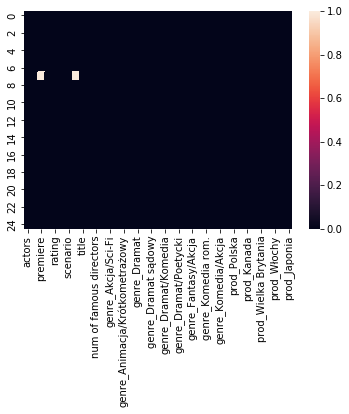

In [238]:
#checking NaN values
sns.heatmap(movies_info_table.isnull())

## Exploratory data analysis

In [2]:
movies_info = pd.read_json('data/filmweb_data')

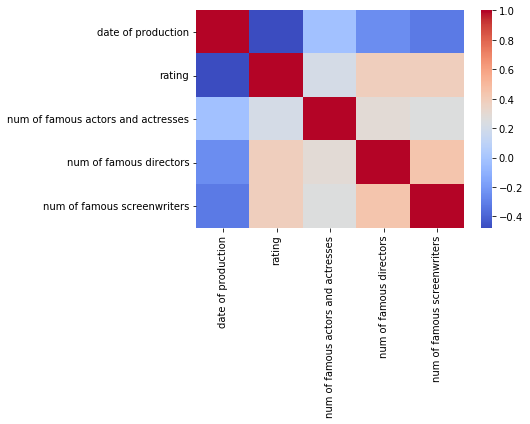

In [3]:
sns.heatmap(movies_info[['date of production','rating','num of famous actors and actresses',
                               'num of famous directors','num of famous screenwriters']].corr(), cmap='coolwarm')

We can see that big impact on a rating has a number of famous directors and screenwriters. Number of famous actors and actresses has smaller impact. Now we will check how a mean rating depends on a different variables.

Now we will check mean rating of movies produced in different countries

In [5]:
countries = []

for column in movies_info.columns:
    if 'prod_' in column:
        countries.append(column.split('_')[-1])
        
countries_mean_ratings = pd.DataFrame({'country': countries})
countries_mean_ratings.set_index('country', inplace = True)
countries_mean_ratings['mean_rating'] = np.nan
countries_mean_ratings['no_movies'] = np.nan
        
for country in countries:
    mean_value = movies_info[movies_info.production.apply(lambda x: country in x)].rating.mean()
    no_movies = len(movies_info[movies_info.production.apply(lambda x: country in x)])
    countries_mean_ratings.loc[country] = [mean_value, no_movies]
    
countries_mean_ratings[countries_mean_ratings.no_movies >= 3].sort_values('mean_rating', ascending = False)
# countries_mean_ratings

,mean_rating,no_movies
country,,
Brazylia,8.166667,3.0
Islandia,7.933333,3.0
RFN,7.920000,10.0
ZSRR,7.760000,5.0
Japonia,7.634375,32.0
Austria,7.566667,3.0
Holandia,7.500000,3.0
Hongkong,7.457143,7.0
Włochy,7.403571,28.0


We see that countries which have the biggest mean rating have also very little number of movies produced.

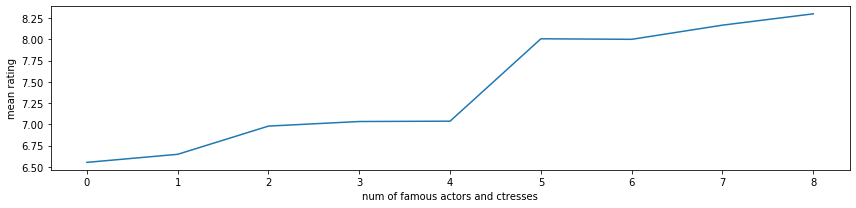

In [6]:
fig,axes = plt.subplots(figsize=(12,3))
axes.plot(movies_info.groupby('num of famous actors and actresses').rating.mean())
axes.set_ylabel('mean rating')
axes.set_xlabel('num of famous actors and ctresses')
plt.tight_layout()

A number of famous actors doesn't seem to have a big impact on a rating, only movies with at least 5 famous actors has significantly bigger mean rating.

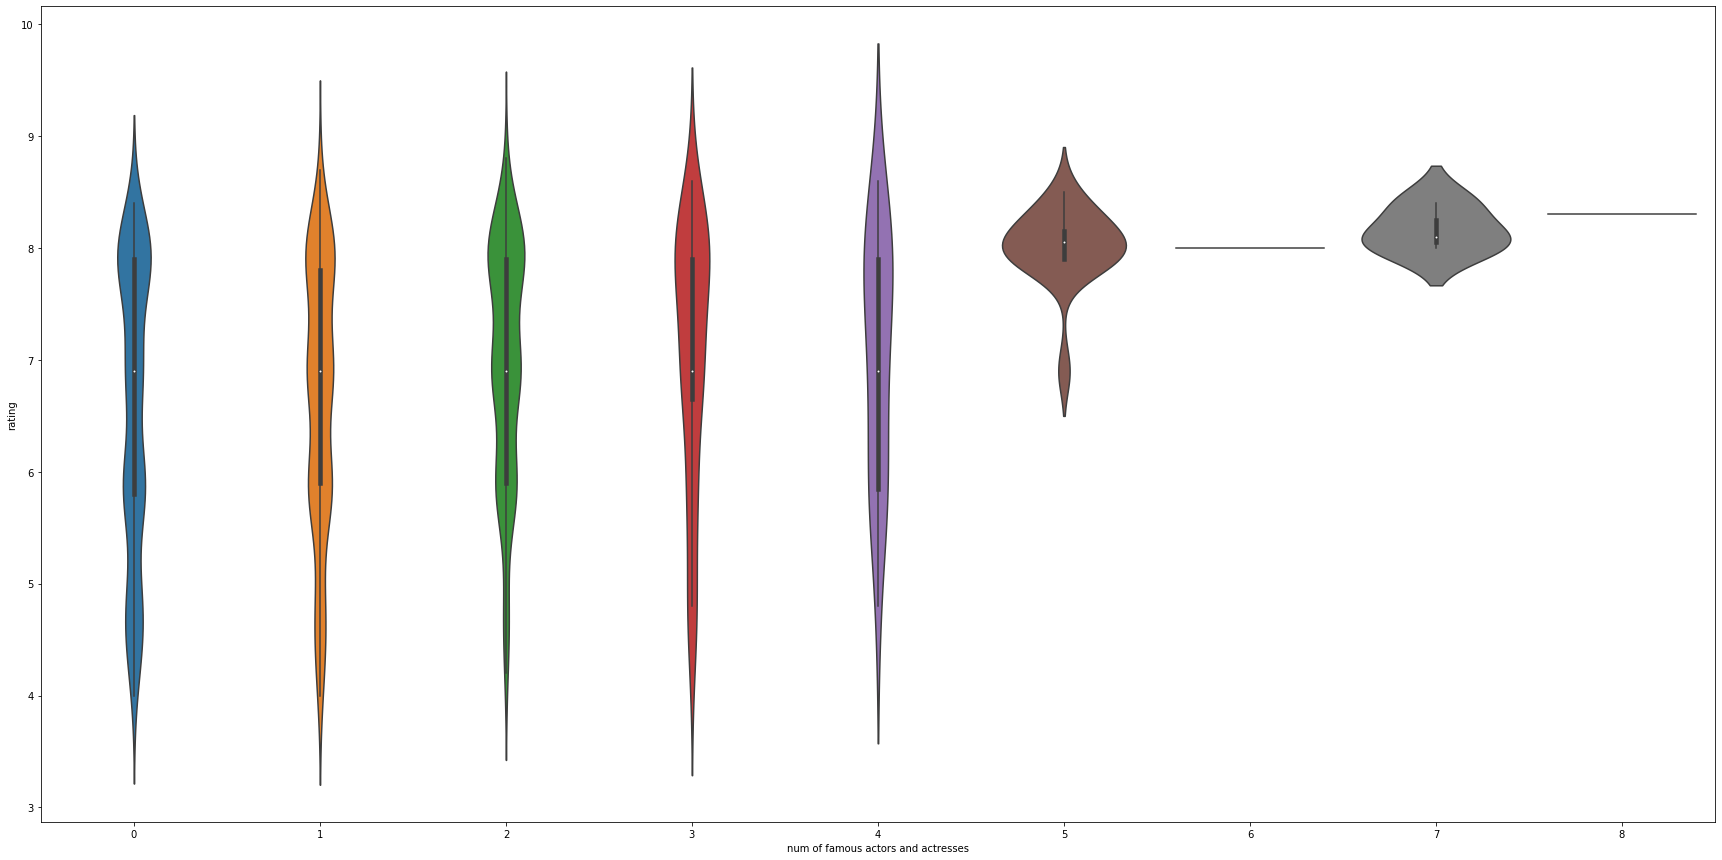

In [25]:
fig, axes = plt.subplots(figsize = (30, 15))

no_famous_actors = 0
sns.violinplot(data = movies_info, y = 'rating', x = 'num of famous actors and actresses')

Here another graph shows that movies with 0-4 famous actors and actresses have similar rating distribution but when we have 5 or 7 then we have much higher ratings.

In [290]:
pd.DataFrame(movies_info.groupby('num of famous directors').rating.mean().sort_values(ascending=False))

,rating
num of famous directors,
1,7.818182
0,6.100000


In [291]:
pd.DataFrame(movies_info.groupby('num of famous screenwriters').rating.mean().sort_values(ascending=False))

,rating
num of famous screenwriters,
2,8.400000
1,8.380000
0,6.135294


We can see that if we have at least one famous screenwriter or director then a mean rating is much bigger, but there is no difference if we have one or two famous screenwriters or directors.

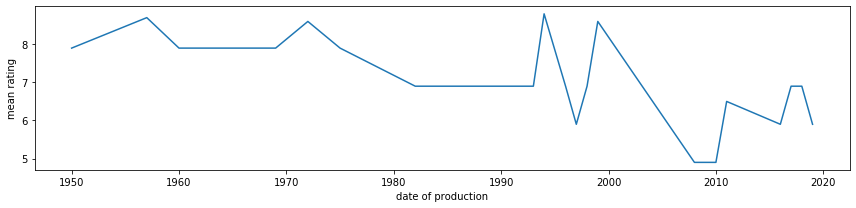

In [294]:
fig,axes=plt.subplots(figsize=(12,3))
axes.plot(movies_info.groupby('date of production').rating.mean())
axes.set_xlabel('date of production')
axes.set_ylabel('mean rating')
plt.tight_layout()

The movies produced after around 1980 start to getting smaller mean rate and the biggest drop is between 2019 and 2020. Let's check a number of movies with rating above 7.5 which was produced before and after 1980.

In [68]:
print('Number of movies with rating above 7.5 produced after 1980: {}'
      .format(df1[(df1['date of production']>1980)&(df1['rating']>7.5)]['rating'].count()))

Number of movies with rating above 7.5 produced after 1980: 113


In [69]:
print('Number of movies with rating above 7.5 produced before 1980: {}'
      .format(df1[(df1['date of production']<1980)&(df1['rating']>7.5)]['rating'].count()))

Number of movies with rating above 7.5 produced before 1980: 67


We can see that even though a mean rating of movies produced after 1980 start to getting smaller, a number of movies with a rating above 7.5 is almost two times bigger. Now let's see what are the movies with the biggest revenue and how it depends on a number of famous actors, screenwriters and directors.

Now we will create some models and try to predict a rating of a movie. In order to check which one is the best we will calculate a root mean square error.

## content based recommendation system

Here I recommend movies which have similar features like actors, screenwriters, genre and so on.

In [27]:
movies_info = pd.read_json('data/filmweb_data')

In [28]:
movies_info.shape

(902, 140)

In [29]:
i = 0
movies_info.iloc[ : 5, i * 10 : (i + 1) * 10]

,actors,date of production,genre,premiere,production,rating,directing,scenario,studio,title
0,"[Marcin Dorociński, Urszula Grabowska, Karolin...",2009,[Komedia rom.],1.250813e+12,[Polska],4.9,[Krzysztof Lang],"[Anita Nawrocka, Paweł Trześniowski]","[Agencja Media Plus, Kino Świat]",Miłość na wybiegu
1,"[Izabella Miko, Mateusz Damięcki, Mariusz Słup...",2009,"[Komedia rom., Muzyczny]",1.236298e+12,[Polska],4.9,[Bruce Parramore],[Maciej Kowalewski],"[Polski Instytut Sztuki Filmowej, TVN]",Kochaj i tańcz
2,"[Brian Hallisay, Sarah Habel, John Hensley, Th...",2011,[Horror],1.324598e+12,[USA],4.9,[Scott Spiegel],[Michael D. Weiss],"[Raw Nerve, RCR Media Group, Stage 6 Films]",Hostel 3
3,"[Kinga Preis, Tomasz Karolak, Joanna Kulig, Ja...",2010,"[Dramat, Komedia obycz.]",1.305245e+12,[Polska],4.9,[Janusz Kondratiuk],"[Janusz Kondratiuk, Dominik W. Rettinger]",[HBO Polska],Milion dolarów
4,"[Christa Campbell, Ving Rhames, Nick Cannon, A...",2008,[Horror],1.207613e+12,[USA],4.9,[Steve Miner],[Jeffrey Reddick],[Millennium Films],Dzień żywych trupów


In [6]:
# creating soup column (containing all important words from other columnes defined as features)

def clean_data1(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
        
def clean_data2(x):
    if isinstance(x, list):
        return [str.lower(i) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

features = ['genre', 'actors', 'directing', 'scenario', 'studio']
features_columns = pd.DataFrame()

for feature in features:
    if feature != 'genre':
        features_columns = pd.concat((features_columns, movies_info[feature].apply(lambda x: clean_data1(x))), axis = 1)
    else:features_columns = pd.concat((features_columns, movies_info[feature].apply(lambda x: clean_data2(x))), axis = 1)
        
    
movies_info['soup'] = features_columns.apply(lambda x: ' '.join(x[0]) + ' ' + ' '.join(x[1]) + ' ' + ' '.join(x[2]) + ' ' + ' '.join(x[3]) + ' ' + ' '.join(x[4]), axis = 1)

In [9]:
movies_info.soup.iloc[0]

'komedia rom. marcindorociński urszulagrabowska karolinagorczyca tomaszkarolak enriquealcides patriciakazadi karolinamalinowska-janiak ilonamontana olgafrycz mareklitewka zbigniewlesień mateuszjanicki krzysztoflang anitanawrocka pawełtrześniowski agencjamediaplus kinoświat'

In [10]:
vectorizer = CountVectorizer()
movies_vectors = vectorizer.fit_transform(movies_info['soup'])

In [11]:
movies_similarities = cosine_similarity(movies_vectors, movies_vectors)

In [16]:
def get_recommendations(dataframe, title, similarities):
    # Get the index of the movie that matches the title
    idx = dataframe[dataframe.title == title].index[0]

    # create table with titles and their similarity scores
    scores = pd.DataFrame(dataframe.title)
    scores['score'] = pd.DataFrame(similarities[idx])
    
    # select the top 10 most similar movies
    recom_movies = scores.sort_values(by = 'score', ascending = False).title.iloc[1 : 11]

    return recom_movies

In [20]:
# check recommendations

title = movies_info.loc[0, 'title']
print(title, '\n')
get_recommendations(movies_info, title, movies_similarities)

Miłość na wybiegu 



116    Idealny facet dla mojej dziewczyny
131                    Miłość do kwadratu
222                     Tylko mnie kochaj
477                           Listy do M.
215                    Narzeczony na niby
274                          Rozmowy nocą
105                    Pech to nie grzech
37               Dzień dobry, kocham cię!
193              Pokojówka na Manhattanie
245             Anglik, który mnie kochał
Name: title, dtype: object

## Regression with Support Vector Regression

In [6]:
movies_info = pd.read_json('data/filmweb_data')

In [7]:
# remove columns with non numerical values

for column in movies_info.dtypes.index:
    if movies_info.dtypes.loc[column] not in ['int64', 'float64']:
        # print(column)
        movies_info.drop(column, inplace = True, axis = 1)

In [91]:
movies_info.head()

,date of production,premiere,rating,num of famous actors and actresses,num of famous directors,num of famous screenwriters,Akcja,Animacja,Animacja dla dorosłych,Anime,...,prod_Tunezja,prod_Turcja,prod_USA,prod_Wenezuela,prod_Wielka Brytania,prod_Węgry,prod_Włochy,prod_ZSRR,prod_Zjednoczone Emiraty Arabskie,prod_Łotwa
0,2009,1.250813e+12,4.9,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2009,1.236298e+12,4.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011,1.324598e+12,4.9,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2010,1.305245e+12,4.9,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2008,1.207613e+12,4.9,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [8]:
from sklearn import metrics
from sklearn import svm
import numpy as np
from sklearn.model_selection import train_test_split

x=movies_info.drop(['rating', 'premiere'],axis=1)
y=movies_info['rating']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

regr = svm.SVR()
regr.fit(x_train,y_train)
pred=regr.predict(x_test)

rmse = np.sqrt(metrics.mean_squared_error(y_test, pred))
                
print('mean RMSE:{}'.format(rmse))

mean RMSE:1.2788132579502391


In [13]:
from sklearn.model_selection import GridSearchCV
param={'C':[0.001,0.01,0.1,1,10,100,1000],'epsilon':[0.001,0.01,0.1,1,10,100,1000]}
grid = GridSearchCV(svm.SVR(), param, refit=True, verbose=0)
grid.fit(x_train,y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'epsilon': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [115]:
grid.best_params_

{'C': 1000, 'epsilon': 0.1}

In [104]:
pred=grid.predict(x_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

RMSE: 1.0143017042461646


## Classification with Logistic Regression

Now let's try classification models. In order to do that, we will round up rating values such that their type is int.

In [14]:
movies_info['rating'] = movies_info.rating.apply(lambda x: round(x))

In [15]:
movies_info['rating'].value_counts()

8    353
7    200
6    200
5     92
4     52
9      5
Name: rating, dtype: int64

In [18]:
x=movies_info.drop(['rating', 'premiere'],axis=1)
y=movies_info['rating']

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.3)

In [25]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier()
model.fit(x_train,y_train)
pred=model.predict(x_test)

print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[ 1  5  7  1  2  0]
 [ 2  4  9  5  3  0]
 [ 6  4 34  9  7  0]
 [ 2  5  8 24 18  0]
 [ 1  0  6 14 92  2]
 [ 0  0  0  0  0  0]]
              precision    recall  f1-score   support

           4       0.08      0.06      0.07        16
           5       0.22      0.17      0.20        23
           6       0.53      0.57      0.55        60
           7       0.45      0.42      0.44        57
           8       0.75      0.80      0.78       115
           9       0.00      0.00      0.00         0

    accuracy                           0.57       271
   macro avg       0.34      0.34      0.34       271
weighted avg       0.56      0.57      0.56       271



c:\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
